In [1]:
# ============================================================================
# KONFIGURACJA KLUCZY API
# ============================================================================
# 
# WYMAGANE DO PROJEKTU:
# ----------------------
# ❌ ŻADEN KLUCZ NIE JEST WYMAGANY - projekt działa lokalnie z CLIP!
#
# OPCJONALNE (lepsze rozpoznawanie):
# ----------------------------------
# 
# 1. OPENAI_API_KEY (💰 PŁATNE)
#    - Koszt: ~$0.01-0.03 za obraz (gpt-4o-mini)
#    - Najlepsze rozpoznawanie części metalowych
#    - https://platform.openai.com/api-keys
#
# 2. GOOGLE_API_KEY (🆓 DARMOWE - 1000 zapytań/miesiąc)
#    - Google Cloud Vision API
#    - https://console.cloud.google.com/apis/credentials
#
# 3. HUGGINGFACEHUB_API_TOKEN (🆓 DARMOWE)
#    - Hugging Face Inference API
#    - https://huggingface.co/settings/tokens
#
# FALLBACK (🆓 ZAWSZE DZIAŁA):
# ----------------------------
# Jeśli żaden klucz nie jest ustawiony, system używa:
# → CLIP Embedding (lokalnie, offline, darmowe)
#
# ============================================================================

import os

# Ustaw klucze API (odkomentuj i uzupełnij jeśli masz):
# os.environ["OPENAI_API_KEY"] = "sk-..."           # 💰 Płatne
# os.environ["GOOGLE_API_KEY"] = "..."              # 🆓 Darmowe (1000/mies)
# os.environ["HUGGINGFACEHUB_API_TOKEN"] = "hf_..." # 🆓 Darmowe

# Sprawdź status kluczy
print("=" * 60)
print("STATUS KLUCZY API")
print("=" * 60)

keys = {
    "OPENAI_API_KEY": ("💰 Płatne", "OpenAI Vision (najlepsze)"),
    "GOOGLE_API_KEY": ("🆓 Darmowe", "Google Vision (1000/mies)"),
    "HUGGINGFACEHUB_API_TOKEN": ("🆓 Darmowe", "Hugging Face (captioning)")
}

any_key = False
for key, (cost, desc) in keys.items():
    value = os.getenv(key)
    if value:
        print(f"✓ {key}: USTAWIONY {cost}")
        any_key = True
    else:
        print(f"✗ {key}: brak ({cost})")

print("-" * 60)
if any_key:
    print("📡 Metoda: API (zewnętrzne rozpoznawanie)")
else:
    print("📡 Metoda: CLIP Embedding (lokalnie, offline)")
    print("   → Działa bez kluczy API!")
print("=" * 60)

STATUS KLUCZY API
✗ OPENAI_API_KEY: brak (💰 Płatne)
✗ GOOGLE_API_KEY: brak (🆓 Darmowe)
✗ HUGGINGFACEHUB_API_TOKEN: brak (🆓 Darmowe)
------------------------------------------------------------
📡 Metoda: CLIP Embedding (lokalnie, offline)
   → Działa bez kluczy API!


In [2]:
# instalacja pakietów - obowiązkowo przed uruchomieniem
%pip install -q sentence-transformers transformers pillow sqlalchemy torch numpy pandas requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# RAG System dla Wyszukiwania Części Metalowych z API

## 🎯 Funkcjonalność
System analizuje obrazy części metalowych używając zewnętrznych API i zapisuje wyniki w bazie danych SQLite.

## 🔑 Wymagane API (opcjonalne, system działa z dowolnym z nich)

### Opcja 1: OpenAI Vision API (ZALECANE)
```bash
export OPENAI_API_KEY="sk-..."  # Linux/Mac
set OPENAI_API_KEY=sk-...       # Windows CMD
$env:OPENAI_API_KEY="sk-..."    # Windows PowerShell
```

### Opcja 2: Google Vision API
```bash
export GOOGLE_API_KEY="..."
```

### Opcja 3: Hugging Face (fallback)
```bash
export HUGGINGFACEHUB_API_TOKEN="hf_..."
```

## 📊 Baza Danych
- **Typ**: SQLite (`metal_parts.db`)
- **Tabele**: `metal_parts`, `search_logs`
- **Zapisywane dane**: part_id, description, material, category, dimensions, tags, image_path, embeddings, created_at

## 🚀 Jak używać
1. Ustaw zmienną środowiskową z kluczem API (min. jeden)
2. Uruchom komórki 1-7 (inicjalizacja)
3. Uruchom komórkę 17 (przetworzenie obrazów z `obrazy/metal/`)
4. Obrazy zostaną rozpoznane przez API i zapisane w bazie

## 📁 Struktura zapisanych danych
```
{
  "part_id": "BEA-M1",
  "description": "Bearing",
  "material": "Stal chromowana", 
  "category": "bearings",
  "dimensions": {"source": "openai_vision_api", "raw_info": "..."},
  "tags": ["metal", "part", "bearings", "api_recognized"],
  "image_path": "obrazy/metal/m1.jpg",
  "created_at": "2025-12-29T..."
}
```

## 1. Inicjalizacja i Konfiguracja

In [3]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import torch
import numpy as np
from pathlib import Path
from typing import List, Optional, Dict
from dataclasses import dataclass
from datetime import datetime

from sqlalchemy import create_engine, Column, Integer, String, Float, JSON, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, Session, relationship
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
import requests

# config
EMBEDDING_MODEL = "clip-ViT-B-32"
LLM_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DATABASE_URL = "sqlite:///metal_parts.db"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"✓ Urządzenie: {DEVICE}")
print(f"✓ Baza danych: {DATABASE_URL}")

# baza danych
Base = declarative_base()
engine = create_engine(DATABASE_URL, echo=False)
SessionLocal = sessionmaker(bind=engine)

c:\Users\hubik\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Urządzenie: cpu
✓ Baza danych: sqlite:///metal_parts.db


## 2. Modele Danych

In [4]:
@dataclass
class MetalPart:
    """Część metalowa"""
    part_id: str
    description: str
    material: str
    category: str
    dimensions: Dict
    tags: List[str]
    image_path: Optional[str] = None
    image_embedding: Optional[List[float]] = None
    text_embedding: Optional[List[float]] = None


class PartDB(Base):
    """Model SQLAlchemy"""
    __tablename__ = "metal_parts"

    id = Column(Integer, primary_key=True, autoincrement=True)
    part_id = Column(String, unique=True, nullable=False)
    description = Column(String, nullable=False)
    material = Column(String, nullable=True)
    category = Column(String, nullable=True)
    dimensions = Column(JSON, nullable=True)
    tags = Column(JSON, nullable=True)
    image_path = Column(String, nullable=True)
    image_embedding = Column(String, nullable=True)
    text_embedding = Column(String, nullable=True)
    created_at = Column(String, nullable=True)


class SearchLog(Base):
    """Log wyszukiwań"""
    __tablename__ = "search_logs"

    id = Column(Integer, primary_key=True, autoincrement=True)
    query = Column(String, nullable=False)
    query_type = Column(String, nullable=False)
    top_k = Column(Integer, nullable=True)
    results_count = Column(Integer, nullable=True)
    timestamp = Column(String, nullable=True)

def init_database():
    """Tworzy tabele"""
    Base.metadata.create_all(engine)
    print("✓ Baza danych zainicjalizowana")

init_database()

✓ Baza danych zainicjalizowana


## 3. Embeddingi i Ekstrakcja Cech

In [5]:
# model embeddingów
print("Ładowanie modelu embeddingów...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=DEVICE)
print(f"✓ Model embeddingów załadowany: {EMBEDDING_MODEL}")

def get_text_embedding(text: str) -> List[float]:
    """Tekst -> embedding"""
    embedding = embedding_model.encode(text, normalize_embeddings=True)
    return embedding.tolist()


def get_image_embedding(image_path: str) -> List[float]:
    """Obraz -> embedding"""
    from PIL import Image
    try:
        img = Image.open(image_path).convert('RGB')
        img_embedding = embedding_model.encode(img, normalize_embeddings=True)
        return img_embedding.tolist()
    except Exception as e:
        print(f"✗ Błąd wczytywania obrazu {image_path}: {e}")
        return None


def build_part_text(part: MetalPart) -> str:
    """Opis części do embeddingu"""
    dims_str = ", ".join([f"{k}: {v}" for k, v in (part.dimensions or {}).items()])
    tags_str = ", ".join(part.tags)

    text = f"""
    Część metalowa: {part.description}
    ID: {part.part_id}
    Kategoria: {part.category}
    Materiał: {part.material}
    Wymiary: {dims_str}
    Tagi: {tags_str}
    """
    return text


# test
test_text = "Śruba sześciokątna M8 ze stali nierdzewnej"
test_emb = get_text_embedding(test_text)
print(f"\n✓ Test embeddingu tekstowego:")
print(f"  Tekst: {test_text}")
print(f"  Długość embeddingu: {len(test_emb)}D")
print(f"  Pierwsze 5 wartości: {test_emb[:5]}")

Ładowanie modelu embeddingów...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ Model embeddingów załadowany: clip-ViT-B-32

✓ Test embeddingu tekstowego:
  Tekst: Śruba sześciokątna M8 ze stali nierdzewnej
  Długość embeddingu: 512D
  Pierwsze 5 wartości: [-0.015048499219119549, -0.011767568998038769, -0.004894441459327936, -0.006681033410131931, 0.0004228035104461014]


## 4. Funkcje do Indeksowania Części

In [6]:
def add_part_to_db(db: Session, part: MetalPart) -> bool:
    """Dodaje część do bazy"""
    try:
        text_desc = build_part_text(part)
        text_emb = get_text_embedding(text_desc)

        image_emb = None
        if part.image_path and Path(part.image_path).exists():
            image_emb = get_image_embedding(part.image_path)

        text_emb_str = ";".join(str(x) for x in text_emb) if text_emb else None
        image_emb_str = ";".join(str(x) for x in image_emb) if image_emb else None

        db_part = PartDB(
            part_id=part.part_id,
            description=part.description,
            material=part.material,
            category=part.category,
            dimensions=part.dimensions,
            tags=part.tags,
            image_path=part.image_path,
            text_embedding=text_emb_str,
            image_embedding=image_emb_str,
            created_at=datetime.now().isoformat()
        )
        db.add(db_part)
        db.commit()
        return True
    except Exception as e:
        print(f"✗ Błąd dodawania części: {e}")
        return False


def load_parts_from_db(db: Session) -> List[PartDB]:
    """Pobiera części z bazy"""
    return db.query(PartDB).all()


def parse_embedding_from_db(emb_str: str) -> List[float]:
    """String -> lista floatów"""
    if not emb_str:
        return None
    return [float(x) for x in emb_str.split(";")]


def cosine_similarity(a: List[float], b: List[float]) -> float:
    """Cosine similarity"""
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

print("✓ Funkcje indeksowania załadowane")

✓ Funkcje indeksowania załadowane


## 5. Retriever - Wyszukiwanie Podobnych Części

In [7]:
def search_parts_by_text(db: Session, query: str, top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Szukaj części po tekście (CLIP text-to-image)"""
    query_emb = get_text_embedding(query)
    all_parts = load_parts_from_db(db)

    results = []
    for part in all_parts:
        if category_filter and part.category != category_filter:
            continue

        part_emb = parse_embedding_from_db(part.image_embedding)
        if not part_emb:
            continue

        score = cosine_similarity(query_emb, part_emb)
        results.append((part, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


def search_parts_by_image(db: Session, image_path: str, top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Szukaj części po obrazie"""
    query_emb = get_image_embedding(image_path)
    if not query_emb:
        return []

    all_parts = load_parts_from_db(db)

    results = []
    for part in all_parts:
        if category_filter and part.category != category_filter:
            continue

        part_emb = parse_embedding_from_db(part.image_embedding)
        if not part_emb:
            continue

        score = cosine_similarity(query_emb, part_emb)
        results.append((part, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


def search_parts_hybrid(db: Session, text_query: str, image_path: Optional[str] = None,
                       top_k: int = 5, category_filter: Optional[str] = None) -> List[tuple]:
    """Szukaj hybrydowo: tekst + obraz"""
    text_results = search_parts_by_text(db, text_query, top_k=top_k*2, category_filter=category_filter)

    if image_path and Path(image_path).exists():
        image_results = search_parts_by_image(db, image_path, top_k=top_k*2, category_filter=category_filter)

        combined = {}
        for part, score in text_results:
            combined[part.id] = {"part": part, "score": score * 0.7}

        for part, score in image_results:
            if part.id in combined:
                combined[part.id]["score"] += score * 0.3
            else:
                combined[part.id] = {"part": part, "score": score * 0.3}

        results = [(v["part"], v["score"]) for v in combined.values()]
    else:
        results = text_results

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]

print("✓ Retriever załadowany")

✓ Retriever załadowany


## 6. LLM - Generacja Raportu

In [8]:
# model LLM
print("Ładowanie modelu LLM...")
try:
    tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL)
    llm_model = AutoModelForCausalLM.from_pretrained(LLM_MODEL, low_cpu_mem_usage=True)
    llm_model.to(DEVICE)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print(f"✓ LLM załadowany: {LLM_MODEL}")
except Exception as e:
    print(f"✗ Błąd ładowania LLM: {e}")
    llm_model = None
    tokenizer = None


def generate_report(results: List[tuple], query: str) -> str:
    """Generuj raport LLM"""
    if not llm_model or not tokenizer:
        return generate_simple_report(results, query)

    context = "\n\n".join([
        f"Część {i+1}:\n"
        f"  ID: {part.part_id}\n"
        f"  Opis: {part.description}\n"
        f"  Materiał: {part.material}\n"
        f"  Kategoria: {part.category}\n"
        f"  Wymiary: {part.dimensions}\n"
        f"  Tagi: {', '.join(part.tags or [])}\n"
        f"  Dopasowanie: {score*100:.1f}%"
        for i, (part, score) in enumerate(results)
    ])

    prompt = f"""
    Użytkownik szuka części metalowych. Zapytanie: "{query}"

    Znalezione części:
    {context}

    Na podstawie wyników wyszukiwania, wygeneruj krótki, rzeczowy raport o znalezionych częściach.
    Wskaż, które części najlepiej pasują do zapytania i dlaczego.
    """

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(DEVICE)

    with torch.no_grad():
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("Na podstawie wyników")[-1].strip() if "Na podstawie wyników" in response else response


def generate_simple_report(results: List[tuple], query: str) -> str:
    """Prosty raport tekstowy"""
    report = f"RAPORT WYSZUKIWANIA\n"
    report += f"Zapytanie: {query}\n"
    report += f"Znaleziono: {len(results)} części\n"
    report += "\n" + "="*60 + "\n\n"

    for i, (part, score) in enumerate(results, 1):
        report += f"#{i} (Dopasowanie: {score*100:.1f}%)\n"
        report += f"  ID: {part.part_id}\n"
        report += f"  Opis: {part.description}\n"
        report += f"  Materiał: {part.material}\n"
        report += f"  Kategoria: {part.category}\n"
        if part.dimensions:
            report += f"  Wymiary: {part.dimensions}\n"
        if part.tags:
            report += f"  Tagi: {', '.join(part.tags)}\n"
        report += "\n"

    return report

print("✓ Funkcje generacji raportu załadowane")

Ładowanie modelu LLM...
✓ LLM załadowany: TinyLlama/TinyLlama-1.1B-Chat-v1.0
✓ Funkcje generacji raportu załadowane


## 7. Główna Funkcja RAG

In [9]:
def rag_search_metal_parts(query: str, query_type: str = "text", image_path: Optional[str] = None,
                          category_filter: Optional[str] = None, top_k: int = 5) -> Dict:
    """Główna funkcja RAG"""
    with SessionLocal() as db:
        if query_type == "text":
            results = search_parts_by_text(db, query, top_k=top_k, category_filter=category_filter)
        elif query_type == "image":
            if not image_path:
                return {"error": "Brak ścieżki do obrazu dla query_type='image'."}
            results = search_parts_by_image(db, image_path, top_k=top_k, category_filter=category_filter)
        elif query_type == "hybrid":
            if not image_path:
                return {"error": "Brak ścieżki do obrazu dla query_type='hybrid'."}
            results = search_parts_hybrid(db, query, image_path=image_path, top_k=top_k, category_filter=category_filter)
        else:
            return {"error": f"Nieznany typ wyszukiwania: {query_type}"}

        results_dicts = [
            ({
                "id": part.id,
                "part_id": part.part_id,
                "description": part.description,
                "material": part.material,
                "category": part.category,
                "dimensions": part.dimensions,
                "tags": part.tags,
                "image_path": part.image_path,
                "created_at": part.created_at,
                "similarity_score": float(score),
            }, score)
            for part, score in results
        ]

        report = generate_simple_report(results, query)

        log = SearchLog(
            query=query,
            query_type=query_type,
            top_k=top_k,
            results_count=len(results),
            timestamp=datetime.now().isoformat(),
        )
        db.add(log)
        db.commit()

        return {
            "query": query,
            "query_type": query_type,
            "results": results_dicts,
            "report": report,
            "timestamp": datetime.now().isoformat(),
        }


def display_search_results(results_data: Dict) -> None:
    """Wyświetla wyniki w tabeli"""
    print(f"\n{'='*90}")
    print("WYNIKI WYSZUKIWANIA")
    print(f"{'='*90}")
    print(f"Query: {results_data.get('query', 'N/A')}")
    print(f"Typ: {results_data.get('query_type', 'N/A')}")
    print(f"Timestamp: {results_data.get('timestamp', 'N/A')}")
    print(f"Znaleziono: {len(results_data.get('results', []))} części\n")

    rows = results_data.get('results', [])
    if not rows:
        print("⚠ Brak wyników")
        return

    print(f"{'#':<3} | {'ID':<15} | {'Opis':<35} | {'Materiał':<20} | {'Kategoria':<15} | {'Score':<8}")
    print(f"{'-'*3}-+-{'-'*15}-+-{'-'*35}-+-{'-'*20}-+-{'-'*15}-+-{'-'*8}")

    for i, (part_dict, score) in enumerate(rows, 1):
        part_id = (part_dict.get('part_id') or 'N/A')[:15]
        description = (part_dict.get('description') or 'N/A')[:35]
        material = (part_dict.get('material') or 'N/A')[:20]
        category = (part_dict.get('category') or 'N/A')[:15]
        score_val = f"{score:.4f}"
        print(f"{i:<3} | {part_id:<15} | {description:<35} | {material:<20} | {category:<15} | {score_val:<8}")

    best_match, best_score = rows[0]
    print(f"\n{'='*90}")
    print("SZCZEGÓŁY NAJLEPSZEGO DOPASOWANIA:")
    print(f"{'='*90}")
    print(f"ID bazy danych:    {best_match.get('id', 'N/A')}")
    print(f"Part ID:           {best_match.get('part_id', 'N/A')}")
    print(f"Opis:              {best_match.get('description', 'N/A')}")
    print(f"Materiał:          {best_match.get('material', 'N/A')}")
    print(f"Kategoria:         {best_match.get('category', 'N/A')}")
    print(f"Wymiary:           {best_match.get('dimensions', {})}")
    tags_val = best_match.get('tags') or []
    print(f"Tagi:              {', '.join(tags_val) if tags_val else ''}")
    print(f"Ścieżka obrazu:    {best_match.get('image_path', 'N/A')}")
    print(f"Data utworzenia:   {best_match.get('created_at', 'N/A')}")
    print(f"Similarity score:  {best_score:.4f}")
    print(f"{'='*90}\n")

## 8. Przykładowe Dane i Test

In [10]:
# klasyfikacja obrazów części metalowych
import os
import requests
import json
import base64
from pathlib import Path
from PIL import Image

# API config
HF_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

HF_CAPTION_ENDPOINT = "https://api-inference.huggingface.co/models/Salesforce/blip-image-captioning-base"


def analyze_image_with_openai(image_path: str) -> Optional[Dict]:
    """Analiza przez OpenAI Vision"""
    if not OPENAI_API_KEY:
        return None
    
    try:
        with open(image_path, "rb") as f:
            image_data = base64.b64encode(f.read()).decode('utf-8')
        
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }
        
        payload = {
            "model": "gpt-4o-mini",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": """Analyze this metal part image and provide:
1. Part name (e.g., "Bearing", "Bolt", "Screw", "Nut", "Washer")
2. Material (e.g., "Stal chromowana", "Aluminium", "Stal nierdzewna")
3. Category (e.g., "bearings", "fasteners", "bolts", "nuts")
4. Estimated dimensions if visible
5. Any visible markings or specifications

Respond in JSON format:
{
    "part_name": "string",
    "material": "string", 
    "category": "string",
    "dimensions": "string or null",
    "description": "brief description"
}"""
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{image_data}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 500
        }
        
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=payload,
            timeout=30
        )
        response.raise_for_status()
        
        result = response.json()
        content = result['choices'][0]['message']['content']
        
        try:
            if "```json" in content:
                json_str = content.split("```json")[1].split("```")[0].strip()
            elif "```" in content:
                json_str = content.split("```")[1].split("```")[0].strip()
            else:
                json_str = content.strip()
            
            data = json.loads(json_str)
            return data
        except:
            return {"description": content}
            
    except Exception as e:
        print(f"⚠ Błąd OpenAI Vision API: {e}")
        return None


def analyze_image_with_google(image_path: str) -> Optional[Dict]:
    """Analiza przez Google Vision"""
    if not GOOGLE_API_KEY:
        return None
    
    try:
        from google.cloud import vision
        import io
        
        client = vision.ImageAnnotatorClient()
        
        with io.open(image_path, 'rb') as image_file:
            content = image_file.read()
        
        image = vision.Image(content=content)
        
        response = client.label_detection(image=image)
        labels = response.label_annotations
        
        text_response = client.text_detection(image=image)
        texts = text_response.text_annotations
        
        result = {
            "labels": [label.description for label in labels[:5]],
            "text": texts[0].description if texts else None,
            "confidence": labels[0].score if labels else 0
        }
        
        return result
        
    except Exception as e:
        print(f"⚠ Błąd Google Vision API: {e}")
        return None


def caption_image_online(image_path: str) -> Optional[str]:
    """Caption z Hugging Face"""
    if not HF_API_TOKEN:
        return None
    try:
        with open(image_path, "rb") as f:
            img_bytes = f.read()
        headers = {"Authorization": f"Bearer {HF_API_TOKEN}"}
        resp = requests.post(HF_CAPTION_ENDPOINT, headers=headers, data=img_bytes, timeout=25)
        resp.raise_for_status()
        out = resp.json()
        if isinstance(out, list) and out and isinstance(out[0], dict) and "generated_text" in out[0]:
            return out[0]["generated_text"]
    except Exception as e:
        print(f"⚠ Nie udało się pobrać podpisu z HF: {e}")
    return None


def classify_metal_part_from_image(image_path: str) -> Optional[MetalPart]:
    """Klasyfikuj część z obrazu (OpenAI > Google > CLIP)"""
    try:
        if not Path(image_path).exists():
            print(f"✗ Obraz nie znaleziony: {image_path}")
            return None
        
        img = Image.open(image_path).convert('RGB')
        
        print(f"   🔍 Próba rozpoznania przez OpenAI Vision API...")
        api_result = analyze_image_with_openai(image_path)
        
        if api_result and 'part_name' in api_result:
            print(f"   ✓ OpenAI: {api_result.get('part_name')}")
            
            part_name = api_result.get('part_name', 'Unknown Part')
            material = api_result.get('material', 'Nieznany')
            category = api_result.get('category', 'fasteners')
            description_text = api_result.get('description', part_name)
            dimensions_str = api_result.get('dimensions', '')
            
            img_embedding = embedding_model.encode(img, normalize_embeddings=True)
            part_id = Path(image_path).stem.upper()
            tags = ["metal", "part", category, "api_recognized", image_path]
            if dimensions_str:
                tags.append(f"dim:{dimensions_str}")
            
            dimensions = {
                "source": "openai_vision_api",
                "raw_info": dimensions_str or "not_specified"
            }
            
            part = MetalPart(
                part_id=f"{category.upper()[:3]}-{part_id}",
                description=part_name,
                material=material,
                category=category,
                dimensions=dimensions,
                tags=tags,
                image_path=image_path,
                image_embedding=img_embedding.tolist()
            )
            
            print(f"   ↳ Nazwa: {part_name}")
            print(f"   ↳ Kategoria: {category}")
            print(f"   ↳ Materiał: {material}")
            
            return part
        
        print(f"   🔍 Próba rozpoznania przez Google Vision API...")
        google_result = analyze_image_with_google(image_path)
        
        if google_result and google_result.get('labels'):
            print(f"   ✓ Google Vision: {', '.join(google_result['labels'][:3])}")
        
        print(f"   🔍 Fallback: CLIP embedding...")
        
        caption = caption_image_online(image_path)
        if caption:
            print(f"   ↳ Caption: {caption}")
        
        img_embedding = embedding_model.encode(img, normalize_embeddings=True)
        
        categories = [
            "fasteners", "bearings", "springs", "shafts", "gears",
            "nuts", "bolts", "washers", "plates", "brackets", "pipes",
            "screws", "rivets", "hinges", "clamps"
        ]
        materials = [
            "Stal nierdzewna", "Stal zwykła", "Stal chromowana", "Stal hartowana",
            "Aluminium", "Miedź", "Brąz", "Tytan", "Żeliwo", "Nieznany"
        ]
        
        from scipy.spatial.distance import cosine
        category_embeddings = [embedding_model.encode(f"A {cat} part", normalize_embeddings=True) for cat in categories]
        material_embeddings = [embedding_model.encode(f"Made of {mat}", normalize_embeddings=True) for mat in materials]
        
        category_scores = [1 - cosine(img_embedding, cat_emb) for cat_emb in category_embeddings]
        material_scores = [1 - cosine(img_embedding, mat_emb) for mat_emb in material_embeddings]
        
        best_category = categories[int(np.argmax(category_scores))]
        best_material = materials[int(np.argmax(material_scores))]
        
        category_names = {
            "fasteners": "Fastener", "bearings": "Bearing", "springs": "Spring",
            "shafts": "Shaft", "gears": "Gear", "nuts": "Nut", "bolts": "Bolt",
            "washers": "Washer", "plates": "Plate", "brackets": "Bracket",
            "pipes": "Pipe", "screws": "Screw", "rivets": "Rivet",
            "hinges": "Hinge", "clamps": "Clamp"
        }
        part_name = category_names.get(best_category, best_category.capitalize())
        
        print(f"   ↳ CLIP: {part_name} ({best_category})")
        
        part_id = Path(image_path).stem.upper()
        tags = ["metal", "part", best_category, "clip_classified", image_path]
        
        part = MetalPart(
            part_id=f"{best_category.upper()[:3]}-{part_id}",
            description=part_name,
            material=best_material,
            category=best_category,
            dimensions={"source": "clip_embedding"},
            tags=tags,
            image_path=image_path,
            image_embedding=img_embedding.tolist()
        )
        return part
        
    except Exception as e:
        print(f"✗ Błąd klasyfikacji obrazu {image_path}: {e}")
        import traceback
        traceback.print_exc()
        return None


def classify_parts_from_folder(folder_path: str = "obrazy/metal/") -> List[MetalPart]:
    """Klasyfikuj obrazy z folderu"""
    parts = []
    image_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.bmp']
    
    folder = Path(folder_path)
    if not folder.exists():
        print(f"⚠ Folder nie istnieje: {folder_path}")
        return parts
    
    image_files = []
    for ext in image_extensions:
        image_files.extend(folder.glob(f"*{ext}"))
        image_files.extend(folder.glob(f"*{ext.upper()}"))
    
    if not image_files:
        print(f"⚠ Brak obrazów w folderze: {folder_path}")
        return parts
    
    print(f"\n🔍 Klasyfikowanie {len(image_files)} obrazów z folderu {folder_path}...")
    print(f"📡 API dostępne:")
    print(f"   - OpenAI Vision: {'✓' if OPENAI_API_KEY else '✗'}")
    print(f"   - Google Vision: {'✓' if GOOGLE_API_KEY else '✗'}")
    print(f"   - Hugging Face: {'✓' if HF_API_TOKEN else '✗'}")
    print()
    
    for image_file in sorted(image_files):
        print(f"\n{'='*70}")
        print(f"📷 {image_file.name}")
        print(f"{'='*70}")
        part = classify_metal_part_from_image(str(image_file))
        if part:
            parts.append(part)
            print(f"\n✓ ZAPISANO:")
            print(f"   ID: {part.part_id}")
            print(f"   Nazwa: {part.description}")
            print(f"   Kategoria: {part.category}")
            print(f"   Materiał: {part.material}")
        else:
            print(f"\n✗ Nie udało się sklasyfikować")
    
    print(f"\n{'='*70}")
    print(f"✓ Zaklasyfikowano {len(parts)} z {len(image_files)} obrazów")
    print(f"{'='*70}")
    return parts


def fetch_parts_from_internet() -> List[MetalPart]:
    """Rozpoznaj obrazy przez API"""
    print("📷 Rozpoznawanie części metalowych przez API...")
    parts_from_images = classify_parts_from_folder("obrazy/metal/")
    if parts_from_images:
        print(f"\n✓ Rozpoznano {len(parts_from_images)} części")
        return parts_from_images
    print("\n⚠ Nie znaleziono obrazów lub rozpoznawanie nie powiodło się")
    return []


# rozpoznaj wszystkie obrazy
print("\n" + "="*70)
print("ROZPOZNAWANIE CZĘŚCI METALOWYCH PRZEZ API")
print("="*70)
CURRENT_PARTS = fetch_parts_from_internet()

# dodaj do bazy
with SessionLocal() as db:
    existing = db.query(PartDB).count()
    if existing == 0:
        print(f"\n{'='*70}")
        print(f"DODAWANIE {len(CURRENT_PARTS)} CZĘŚCI DO BAZY DANYCH")
        print(f"{'='*70}\n")
        for part in CURRENT_PARTS:
            success = add_part_to_db(db, part)
            if success:
                print(f"✓ {part.part_id}: {part.description}")
                print(f"  └─ {part.category} | {part.material} | {part.image_path}")
        print(f"\n{'='*70}")
        print(f"✓ {len(CURRENT_PARTS)} części zapisanych w bazie SQLite")
        print(f"{'='*70}\n")
    else:
        print(f"\n✓ Baza zawiera już {existing} części")
        print(f"   Aby ponownie zaindeksować, uruchom komórkę 1 (wyczyść bazę).\n")


ROZPOZNAWANIE CZĘŚCI METALOWYCH PRZEZ API
📷 Rozpoznawanie części metalowych przez API...

🔍 Klasyfikowanie 28 obrazów z folderu obrazy/metal/...
📡 API dostępne:
   - OpenAI Vision: ✗
   - Google Vision: ✗
   - Hugging Face: ✗


📷 m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Bearing (bearings)

✓ ZAPISANO:
   ID: BEA-M1
   Nazwa: Bearing
   Kategoria: bearings
   Materiał: Stal chromowana

📷 m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Bearing (bearings)

✓ ZAPISANO:
   ID: BEA-M1
   Nazwa: Bearing
   Kategoria: bearings
   Materiał: Stal chromowana

📷 m10.webp
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Bearing (bearings)

✓ ZAPISANO:
   ID: BEA-M10
   Nazwa: Bearing
   Kategori

## 9. Testy Wyszukiwania RAG

In [11]:
def add_new_metal_part_from_image(image_path: str) -> bool:
    """Dodaj nową część z obrazu"""
    print(f"\n📷 Klasyfikuję nową część z obrazu: {image_path}")
    
    part = classify_metal_part_from_image(image_path)
    if not part:
        print(f"✗ Nie udało się zaklasyfikować obrazu")
        return False
    
    print(f"\nZaklasyfikowana część:")
    print(f"  ID: {part.part_id}")
    print(f"  Opis: {part.description}")
    print(f"  Kategoria: {part.category}")
    print(f"  Materiał: {part.material}")
    print(f"  Tagi: {', '.join(part.tags)}")
    
    with SessionLocal() as db:
        existing = db.query(PartDB).filter_by(image_path=image_path).first()
        if existing:
            print(f"\n⚠ Część z tego obrazu już istnieje w bazie: {existing.part_id}")
            return False
        
        success = add_part_to_db(db, part)
        if success:
            print(f"\n✓ Część dodana do bazy!")
            return True
        else:
            print(f"\n✗ Błąd podczas dodawania do bazy")
            return False


# test dodawania nowej części
print("\n" + "="*70)
print("TEST: Dodanie Nowej Części z Obrazu")
print("="*70)

test_new_image = "obrazy/metal/m1.jpg"
if Path(test_new_image).exists():
    add_new_metal_part_from_image(test_new_image)
else:
    print(f"⚠ Test image {test_new_image} nie znaleziony")


TEST: Dodanie Nowej Części z Obrazu

📷 Klasyfikuję nową część z obrazu: obrazy/metal/m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Bearing (bearings)

Zaklasyfikowana część:
  ID: BEA-M1
  Opis: Bearing
  Kategoria: bearings
  Materiał: Stal chromowana
  Tagi: metal, part, bearings, clip_classified, obrazy/metal/m1.jpg
✗ Błąd dodawania części: (sqlite3.IntegrityError) UNIQUE constraint failed: metal_parts.part_id
[SQL: INSERT INTO metal_parts (part_id, description, material, category, dimensions, tags, image_path, image_embedding, text_embedding, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ('BEA-M1', 'Bearing', 'Stal chromowana', 'bearings', '{"source": "clip_embedding"}', '["metal", "part", "bearings", "clip_classified", "obrazy/metal/m1.jpg"]', 'obrazy/metal/m1.jpg', '-0.005537155084311962;0.028349721804261208;0.0176918413490057;-0.0013020894257351756;-0.00967

In [12]:
def test_api_recognition(image_path: str):
    """Test rozpoznawania API"""
    print(f"\n{'='*70}")
    print(f"TEST ROZPOZNAWANIA PRZEZ API")
    print(f"{'='*70}")
    print(f"Obraz: {image_path}\n")
    
    print("📡 Status API:")
    print(f"   OpenAI Vision: {'✓ Dostępne' if OPENAI_API_KEY else '✗ Brak klucza (ustaw OPENAI_API_KEY)'}")
    print(f"   Google Vision: {'✓ Dostępne' if GOOGLE_API_KEY else '✗ Brak klucza (ustaw GOOGLE_API_KEY)'}")
    print(f"   Hugging Face:  {'✓ Dostępne' if HF_API_TOKEN else '✗ Brak klucza (ustaw HUGGINGFACEHUB_API_TOKEN)'}")
    print()
    
    if not Path(image_path).exists():
        print(f"✗ Plik nie istnieje: {image_path}")
        return None
    
    part = classify_metal_part_from_image(image_path)
    
    if part:
        print(f"\n{'='*70}")
        print("✓ WYNIK ROZPOZNAWANIA:")
        print(f"{'='*70}")
        print(f"Part ID:      {part.part_id}")
        print(f"Nazwa:        {part.description}")
        print(f"Kategoria:    {part.category}")
        print(f"Materiał:     {part.material}")
        print(f"Wymiary:      {part.dimensions}")
        print(f"Tagi:         {', '.join(part.tags[:5])}")
        print(f"Ścieżka:      {part.image_path}")
        print(f"{'='*70}\n")
        
        save = input("Zapisać do bazy danych? (t/n): ").lower()
        if save == 't':
            with SessionLocal() as db:
                success = add_part_to_db(db, part)
                if success:
                    print(f"✓ Zapisano do bazy!")
                else:
                    print(f"✗ Błąd zapisu")
        
        return part
    else:
        print("\n✗ Nie udało się rozpoznać obrazu")
        return None


# test na przykładowym obrazie
test_image = "obrazy/metal/m1.jpg"
if Path(test_image).exists():
    print("🔍 Testowanie rozpoznawania API na przykładowym obrazie...")
    test_api_recognition(test_image)
else:
    print(f"⚠ Przykładowy obraz nie znaleziony: {test_image}")
    print("   Podaj ścieżkę do obrazu: test_api_recognition('ścieżka/do/obrazu.jpg')")

🔍 Testowanie rozpoznawania API na przykładowym obrazie...

TEST ROZPOZNAWANIA PRZEZ API
Obraz: obrazy/metal/m1.jpg

📡 Status API:
   OpenAI Vision: ✗ Brak klucza (ustaw OPENAI_API_KEY)
   Google Vision: ✗ Brak klucza (ustaw GOOGLE_API_KEY)
   Hugging Face:  ✗ Brak klucza (ustaw HUGGINGFACEHUB_API_TOKEN)

   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Bearing (bearings)

✓ WYNIK ROZPOZNAWANIA:
Part ID:      BEA-M1
Nazwa:        Bearing
Kategoria:    bearings
Materiał:     Stal chromowana
Wymiary:      {'source': 'clip_embedding'}
Tagi:         metal, part, bearings, clip_classified, obrazy/metal/m1.jpg
Ścieżka:      obrazy/metal/m1.jpg

✗ Błąd dodawania części: (sqlite3.IntegrityError) UNIQUE constraint failed: metal_parts.part_id
[SQL: INSERT INTO metal_parts (part_id, description, material, category, dimensions, tags, image_path, image_embedding, text_embedding, created_at) VALUES (?, ?, ?

In [13]:
# reindeksowanie z aktualnym modelem
print("Ponowne indeksowanie części...")
with SessionLocal() as db:
    db.query(PartDB).delete()
    db.commit()

    for part in CURRENT_PARTS:
        success = add_part_to_db(db, part)
        if success:
            print(f"  ✓ Re-indexed: {part.part_id}")
    print("✓ Wszystkie części ponownie zaindeksowane\n")

# test 1: wyszukiwanie tekstowe
print("\n" + "="*70)
print("TEST 1: Wyszukiwanie tekstowe")
print("="*70)

result1 = rag_search_metal_parts(
    query="Szukam śruby metalowej do połączenia części",
    query_type="text",
    top_k=3
)

display_search_results(result1)

Ponowne indeksowanie części z aktualnym modelem embeddingów...
  ✓ Re-indexed: BEA-M1
✗ Błąd dodawania części: (sqlite3.IntegrityError) UNIQUE constraint failed: metal_parts.part_id
[SQL: INSERT INTO metal_parts (part_id, description, material, category, dimensions, tags, image_path, image_embedding, text_embedding, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ('BEA-M1', 'Bearing', 'Stal chromowana', 'bearings', '{"source": "clip_embedding"}', '["metal", "part", "bearings", "clip_classified", "obrazy\\\\metal\\\\m1.jpg"]', 'obrazy\\metal\\m1.jpg', '-0.005537155084311962;0.028349721804261208;0.0176918413490057;-0.0013020894257351756;-0.009676352143287659;-0.01385731715708971;-0.003219104139134288 ... (10542 characters truncated) ... 1;-0.01984461396932602;-0.008059748448431492;-0.020349031314253807;-0.03238809481263161;0.03143991157412529;0.023749761283397675;-0.00754305487498641', '-0.019564110785722733;-0.008709440939128399;0.017348531633615494;-0.017039665952324867

In [14]:
# test 2: wyszukiwanie z filtrem kategorii
print("\n" + "="*70)
print("TEST 2: Wyszukiwanie ze filtrem kategorii (bearings)")
print("="*70)

result2 = rag_search_metal_parts(
    query="Łożysko do maszyny obrotowej",
    query_type="text",
    category_filter="bearings",
    top_k=2
)

display_search_results(result2)


TEST 2: Wyszukiwanie ze filtrem kategorii (bearings)

WYNIKI WYSZUKIWANIA
Query: Łożysko do maszyny obrotowej
Typ: text
Timestamp: 2025-12-31T12:02:28.815816
Znaleziono: 1 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | BEA-M1          | Bearing                             | Stal chromowana      | bearings        | 0.1915  

SZCZEGÓŁY NAJLEPSZEGO DOPASOWANIA:
ID bazy danych:    1
Part ID:           BEA-M1
Opis:              Bearing
Materiał:          Stal chromowana
Kategoria:         bearings
Wymiary:           {'source': 'clip_embedding'}
Tagi:              metal, part, bearings, clip_classified, obrazy\metal\m1.jpg
Ścieżka obrazu:    obrazy\metal\m1.jpg
Data utworzenia:   2025-12-31T12:02:27.028109
Similarity score:  0.1915



In [15]:
# test 3: wyszukiwanie po wymiarach
print("\n" + "="*70)
print("TEST 3: Wyszukiwanie po wymiarach")
print("="*70)

result3 = rag_search_metal_parts(
    query="Wał o średnicy 12mm ze stali chromowanej",
    query_type="text",
    top_k=3
)

display_search_results(result3)


TEST 3: Wyszukiwanie po wymiarach

WYNIKI WYSZUKIWANIA
Query: Wał o średnicy 12mm ze stali chromowanej
Typ: text
Timestamp: 2025-12-31T12:02:28.843725
Znaleziono: 1 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | BEA-M1          | Bearing                             | Stal chromowana      | bearings        | 0.2167  

SZCZEGÓŁY NAJLEPSZEGO DOPASOWANIA:
ID bazy danych:    1
Part ID:           BEA-M1
Opis:              Bearing
Materiał:          Stal chromowana
Kategoria:         bearings
Wymiary:           {'source': 'clip_embedding'}
Tagi:              metal, part, bearings, clip_classified, obrazy\metal\m1.jpg
Ścieżka obrazu:    obrazy\metal\m1.jpg
Data utworzenia:   2025-12-31T12:02:27.028109
Similarity score:  0.2167




TEST 6: Wyświetlanie obrazów znalezionych części

WYNIKI WYSZUKIWANIA
Query: Część z obrazu
Typ: image
Timestamp: 2025-12-31T12:02:29.366082
Znaleziono: 1 części

#   | ID              | Opis                                | Materiał             | Kategoria       | Score   
----+-----------------+-------------------------------------+----------------------+-----------------+---------
1   | BEA-M1          | Bearing                             | Stal chromowana      | bearings        | 0.7785  

SZCZEGÓŁY NAJLEPSZEGO DOPASOWANIA:
ID bazy danych:    1
Part ID:           BEA-M1
Opis:              Bearing
Materiał:          Stal chromowana
Kategoria:         bearings
Wymiary:           {'source': 'clip_embedding'}
Tagi:              metal, part, bearings, clip_classified, obrazy\metal\m1.jpg
Ścieżka obrazu:    obrazy\metal\m1.jpg
Data utworzenia:   2025-12-31T12:02:27.028109
Similarity score:  0.7785



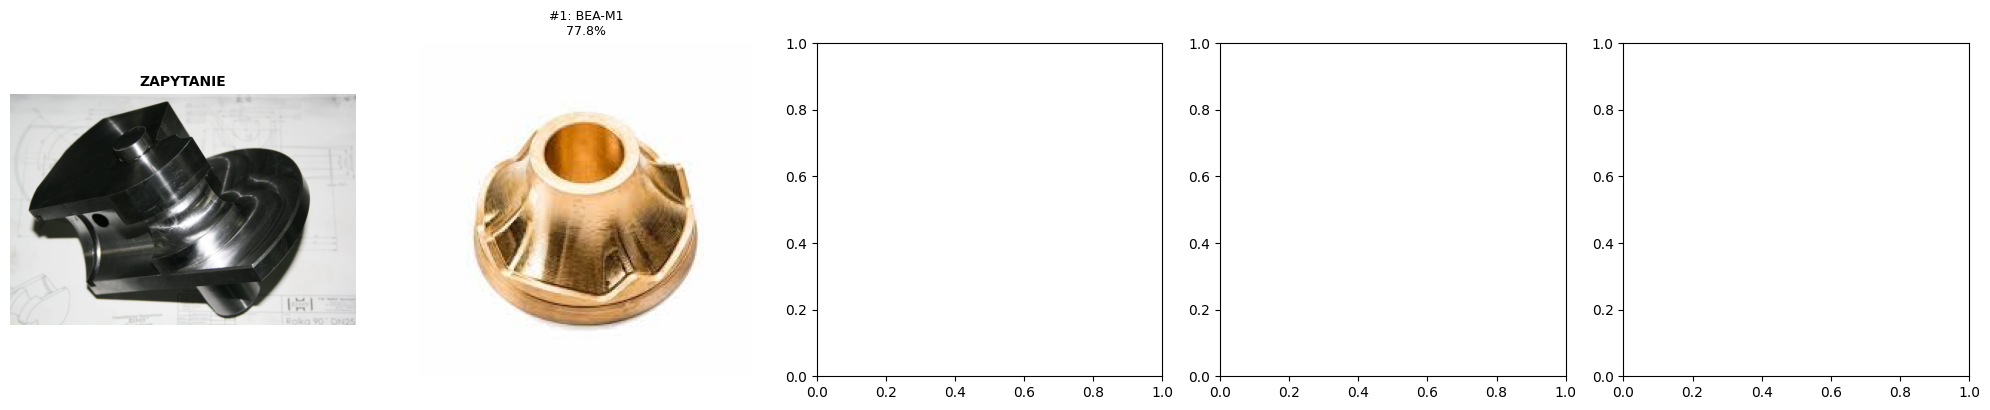


✓ Wyświetlono obraz zapytania i 1 najbardziej podobnych części


In [16]:
# test 6: wizualizacja wyników
print("\n" + "="*70)
print("TEST 6: Wyświetlanie obrazów znalezionych części")
print("="*70)

from PIL import Image
import matplotlib.pyplot as plt

test_image3 = "obrazy/metal/m5.webp"
result6 = rag_search_metal_parts(
    query="Część z obrazu",
    query_type="image",
    image_path=test_image3,
    top_k=4
)

display_search_results(result6)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

if Path(test_image3).exists():
    axes[0].imshow(Image.open(test_image3))
    axes[0].set_title("ZAPYTANIE", fontsize=10, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, "Obraz zapytania\nnie znaleziono", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
    axes[0].set_title("ZAPYTANIE", fontsize=10, fontweight='bold')
axes[0].axis('off')

with SessionLocal() as db:
    for idx, (part_dict, score) in enumerate(result6['results'][:4]):
        part_db = db.query(PartDB).filter_by(part_id=part_dict['part_id']).first()
        if part_db and part_db.image_path and Path(part_db.image_path).exists():
            img = Image.open(part_db.image_path)
            axes[idx+1].imshow(img)
            axes[idx+1].set_title(f"#{idx+1}: {part_dict['part_id']}\n{score*100:.1f}%",
                                 fontsize=9)
            axes[idx+1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Wyświetlono obraz zapytania i {len(result6['results'])} najbardziej podobnych części")

In [17]:
# test 5: wyszukiwanie hybrydowe
print("\n" + "="*70)
print("TEST 5: Wyszukiwanie hybrydowe (tekst + obraz)")
print("="*70)

test_image2 = "obrazy/metal/m3.jpg"
print(f"Wyszukiwanie: tekst + obraz ({test_image2})")

result5 = rag_search_metal_parts(
    query="Łożysko kulkowe do maszyny przemysłowej",
    query_type="hybrid",
    image_path=test_image2,
    top_k=3
)

print(f"\nQuery: {result5['query']}")
print(f"Typ: {result5['query_type']}")
print(f"Obraz zapytania: {test_image2}")
print(f"\nRaport:\n{result5['report']}")


TEST 5: Wyszukiwanie hybrydowe (tekst + obraz)
Wyszukiwanie: tekst + obraz (obrazy/metal/m3.jpg)

Query: Łożysko kulkowe do maszyny przemysłowej
Typ: hybrid
Obraz zapytania: obrazy/metal/m3.jpg

Raport:
RAPORT WYSZUKIWANIA
Zapytanie: Łożysko kulkowe do maszyny przemysłowej
Znaleziono: 1 części


#1 (Dopasowanie: 36.5%)
  ID: BEA-M1
  Opis: Bearing
  Materiał: Stal chromowana
  Kategoria: bearings
  Wymiary: {'source': 'clip_embedding'}
  Tagi: metal, part, bearings, clip_classified, obrazy\metal\m1.jpg




In [18]:
# test 4: wyszukiwanie obrazowe dla wszystkich plików
print("\n" + "="*70)
print("TEST 4: Wyszukiwanie na podstawie obrazu (dla wszystkich obrazów)")
print("="*70)

import glob

image_files = glob.glob("obrazy/metal/*.jpg") + glob.glob("obrazy/metal/*.webp")

if not image_files:
    print("Brak plików obrazów w katalogu 'obrazy/metal'. Upewnij się, że obrazy są przesłane.")
else:
    print(f"\n✓ Znalezione {len(image_files)} plików obrazów\n")
    for idx, test_image in enumerate(image_files, 1):
        print(f"[{idx}/{len(image_files)}] Plik: {test_image}")
        print(f"  Wyszukiwanie podobnych części...")

        result4 = rag_search_metal_parts(
            query="Część metalowa z obrazu",
            query_type="image",
            image_path=test_image,
            top_k=3
        )

        print(f"  ✓ Query: {result4['query']}")
        print(f"  ✓ Typ: {result4['query_type']}")
        print(f"  ✓ Znalezione wyniki: {len(result4['results'])}\n")


TEST 4: Wyszukiwanie na podstawie obrazu (dla wszystkich obrazów)

✓ Znalezione 14 plików obrazów

[1/14] Plik: obrazy/metal\m1.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[2/14] Plik: obrazy/metal\m11.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[3/14] Plik: obrazy/metal\m12.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[4/14] Plik: obrazy/metal\m13.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[5/14] Plik: obrazy/metal\m14.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[6/14] Plik: obrazy/metal\m3.jpg
  Wyszukiwanie podobnych części...
  ✓ Query: Część metalowa z obrazu
  ✓ Typ: image
  ✓ Znalezione wyniki: 1

[7/14] Plik: obrazy/metal\m4.jpg

## Test 4: Wyszukiwanie na podstawie obrazu

## 10. Statystyki i Podsumowanie

In [19]:
# statystyki bazy
with SessionLocal() as db:
    total_parts = db.query(PartDB).count()
    by_category = {}
    for part in db.query(PartDB).all():
        cat = part.category or "unknown"
        by_category[cat] = by_category.get(cat, 0) + 1

    search_logs = db.query(SearchLog).all()

    print("\n" + "="*70)
    print("STATYSTYKI BAZY DANYCH")
    print("="*70)
    print(f"Łączna liczba części: {total_parts}")
    print(f"\nPodzielenie po kategoriach:")
    for cat, count in by_category.items():
        print(f"  - {cat}: {count}")
    print(f"\nLiczba przeprowadzonych wyszukiwań: {len(search_logs)}")

    if search_logs:
        print(f"\nOstatnie wyszukiwania:")
        for log in search_logs[-5:]:
            print(f"  - {log.query_type}: '{log.query}' → {log.results_count} wyników")


STATYSTYKI BAZY DANYCH
Łączna liczba części: 1

Podzielenie po kategoriach:
  - bearings: 1

Liczba przeprowadzonych wyszukiwań: 19

Ostatnie wyszukiwania:
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników
  - image: 'Część metalowa z obrazu' → 1 wyników


In [20]:
# podgląd bazy danych
print("\n" + "="*90)
print("ZAWARTOŚĆ BAZY DANYCH - WSZYSTKIE CZĘŚCI METALOWE")
print("="*90)

with SessionLocal() as db:
    all_parts = db.query(PartDB).all()
    
    if not all_parts:
        print("\n⚠ Baza danych jest pusta")
        print("   Uruchom komórkę 17 aby przetworzyć obrazy\n")
    else:
        print(f"\nLiczba części: {len(all_parts)}\n")
        
        print(f"{'#':<4} | {'Part ID':<15} | {'Nazwa':<25} | {'Kategoria':<12} | {'Materiał':<20} | {'Data':<19}")
        print(f"{'-'*4}-+-{'-'*15}-+-{'-'*25}-+-{'-'*12}-+-{'-'*20}-+-{'-'*19}")
        
        for i, part in enumerate(all_parts, 1):
            part_id = part.part_id[:15]
            name = part.description[:25]
            category = part.category[:12] if part.category else "N/A"
            material = part.material[:20] if part.material else "N/A"
            created = part.created_at[:19] if part.created_at else "N/A"
            
            print(f"{i:<4} | {part_id:<15} | {name:<25} | {category:<12} | {material:<20} | {created:<19}")
        
        print(f"\n{'-'*90}")
        
        by_category = {}
        by_material = {}
        for part in all_parts:
            cat = part.category or "unknown"
            mat = part.material or "unknown"
            by_category[cat] = by_category.get(cat, 0) + 1
            by_material[mat] = by_material.get(mat, 0) + 1
        
        print(f"\n📊 STATYSTYKI:")
        print(f"\nPo kategoriach:")
        for cat, count in sorted(by_category.items(), key=lambda x: x[1], reverse=True):
            print(f"   {cat:.<30} {count:>3}")
        
        print(f"\nPo materiałach:")
        for mat, count in sorted(by_material.items(), key=lambda x: x[1], reverse=True):
            print(f"   {mat:.<30} {count:>3}")
        
        print(f"\n{'-'*90}")
        
        if all_parts:
            print(f"\n📋 PRZYKŁAD - Szczegóły pierwszej części:")
            first = all_parts[0]
            print(f"\n   ID:          {first.part_id}")
            print(f"   Nazwa:       {first.description}")
            print(f"   Kategoria:   {first.category}")
            print(f"   Materiał:    {first.material}")
            print(f"   Wymiary:     {first.dimensions}")
            print(f"   Tagi:        {first.tags}")
            print(f"   Obraz:       {first.image_path}")
            print(f"   Utworzono:   {first.created_at}")
            print(f"\n{'='*90}\n")


ZAWARTOŚĆ BAZY DANYCH - WSZYSTKIE CZĘŚCI METALOWE

Liczba części: 1

#    | Part ID         | Nazwa                     | Kategoria    | Materiał             | Data               
-----+-----------------+---------------------------+--------------+----------------------+--------------------
1    | BEA-M1          | Bearing                   | bearings     | Stal chromowana      | 2025-12-31T12:02:27

------------------------------------------------------------------------------------------

📊 STATYSTYKI:

Po kategoriach:
   bearings......................   1

Po materiałach:
   Stal chromowana...............   1

------------------------------------------------------------------------------------------

📋 PRZYKŁAD - Szczegóły pierwszej części:

   ID:          BEA-M1
   Nazwa:       Bearing
   Kategoria:   bearings
   Materiał:    Stal chromowana
   Wymiary:     {'source': 'clip_embedding'}
   Tagi:        ['metal', 'part', 'bearings', 'clip_classified', 'obrazy\\metal\\m1.jpg']
   Obr

In [21]:
# diagnostyka wyszukiwań obrazowych
print("\n" + "="*70)
print("DIAGNOSTYKA: Analiza wyszukiwań obrazowych")
print("="*70)

with SessionLocal() as db:
    image_searches = db.query(SearchLog).filter_by(query_type="image").all()
    print(f"\nLiczba wyszukiwań obrazowych: {len(image_searches)}")
    
    if image_searches:
        print(f"\nLista wszystkich image searches:")
        for i, log in enumerate(image_searches, 1):
            print(f"  {i}. Query: '{log.query}' | Timestamp: {log.timestamp} | Wyniki: {log.results_count}")
    
    text_searches = db.query(SearchLog).filter_by(query_type="text").count()
    hybrid_searches = db.query(SearchLog).filter_by(query_type="hybrid").count()
    
    print(f"\nPodsumowanie:")
    print(f"  - Tekst (text): {text_searches}")
    print(f"  - Obraz (image): {len(image_searches)}")
    print(f"  - Hybrydowe (hybrid): {hybrid_searches}")
    print(f"  - RAZEM: {text_searches + len(image_searches) + hybrid_searches}")


DIAGNOSTYKA: Analiza wyszukiwań obrazowych

Liczba wyszukiwań obrazowych: 15

Lista wszystkich image searches:
  1. Query: 'Część z obrazu' | Timestamp: 2025-12-31T12:02:29.359575 | Wyniki: 1
  2. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:29.822064 | Wyniki: 1
  3. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:29.858282 | Wyniki: 1
  4. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:29.896116 | Wyniki: 1
  5. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:29.953853 | Wyniki: 1
  6. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:30.006443 | Wyniki: 1
  7. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:30.063172 | Wyniki: 1
  8. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:30.102441 | Wyniki: 1
  9. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:30.142110 | Wyniki: 1
  10. Query: 'Część metalowa z obrazu' | Timestamp: 2025-12-31T12:02:30.216561 | Wyniki

In [22]:
# przetwórz wszystkie obrazy i zapisz do bazy

print("\n" + "="*80)
print("PRZYGOTOWANIE: CZYSZCZENIE BAZY DANYCH")
print("="*80)

with SessionLocal() as db:
    deleted_parts = db.query(PartDB).count()
    deleted_logs = db.query(SearchLog).count()
    
    db.query(PartDB).delete()
    db.query(SearchLog).delete()
    db.commit()
    
    print(f"✓ Usunięto {deleted_parts} części")
    print(f"✓ Usunięto {deleted_logs} logów wyszukiwań")
    print(f"✓ Baza danych wyczyszczona i gotowa do użycia")

print("\n" + "="*80)
print("PRZETWARZANIE: WSZYSTKIE OBRAZY Z FOLDERU 'obrazy/metal/'")
print("="*80)

from pathlib import Path
image_folder = Path("obrazy/metal/")
image_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.bmp']
all_images = []

for ext in image_extensions:
    all_images.extend(image_folder.glob(f"*{ext}"))
    all_images.extend(image_folder.glob(f"*{ext.upper()}"))

all_images = sorted(list(set(all_images)))

print(f"\n📂 Znaleziono {len(all_images)} obrazów do przetworzenia")
print(f"📡 Metoda rozpoznawania: {'OpenAI API' if OPENAI_API_KEY else 'CLIP Embedding (lokalnie)'}\n")

if not all_images:
    print("⚠ Brak obrazów w folderze obrazy/metal/")
    print("   Upewnij się że obrazy są w folderze i uruchom ponownie.")
else:
    processed_parts = []
    
    for i, image_path in enumerate(all_images, 1):
        print(f"\n[{i}/{len(all_images)}] {'='*60}")
        print(f"📷 Plik: {image_path.name}")
        print(f"{'='*70}")
        
        try:
            part = classify_metal_part_from_image(str(image_path))
            
            if part:
                processed_parts.append(part)
                print(f"\n✓ ROZPOZNANO:")
                print(f"   Part ID:    {part.part_id}")
                print(f"   Nazwa:      {part.description}")
                print(f"   Kategoria:  {part.category}")
                print(f"   Materiał:   {part.material}")
            else:
                print(f"\n✗ Nie udało się rozpoznać")
                
        except Exception as e:
            print(f"\n✗ Błąd: {e}")
    
    print(f"\n{'='*80}")
    print(f"ZAPISYWANIE DO BAZY DANYCH: {len(processed_parts)} CZĘŚCI")
    print(f"{'='*80}\n")
    
    with SessionLocal() as db:
        success_count = 0
        for part in processed_parts:
            if add_part_to_db(db, part):
                success_count += 1
                print(f"✓ {part.part_id}: {part.description}")
                print(f"  └─ {part.category} | {part.material}")
        
        print(f"\n{'='*80}")
        print(f"✓✓✓ ZAKOŃCZONO POMYŚLNIE ✓✓✓")
        print(f"{'='*80}")
        print(f"Zapisano:        {success_count}/{len(processed_parts)} części")
        print(f"Baza danych:     metal_parts.db")
        print(f"Tabela:          metal_parts")
        print(f"{'='*80}\n")
        
        print("📋 Przykładowe rekordy w bazie:\n")
        sample_parts = db.query(PartDB).limit(3).all()
        for p in sample_parts:
            print(f"   • {p.part_id}: {p.description} ({p.category}, {p.material})")


PRZYGOTOWANIE: CZYSZCZENIE BAZY DANYCH
✓ Usunięto 1 części
✓ Usunięto 19 logów wyszukiwań
✓ Baza danych wyczyszczona i gotowa do użycia

PRZETWARZANIE: WSZYSTKIE OBRAZY Z FOLDERU 'obrazy/metal/'

📂 Znaleziono 14 obrazów do przetworzenia
📡 Metoda rozpoznawania: CLIP Embedding (lokalnie)


[1/14] ============================================================
📷 Plik: m1.jpg
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Bearing (bearings)

✓ ROZPOZNANO:
   Part ID:    BEA-M1
   Nazwa:      Bearing
   Kategoria:  bearings
   Materiał:   Stal chromowana

[2/14] ============================================================
📷 Plik: m10.webp
   🔍 Próba rozpoznania przez OpenAI Vision API...
   🔍 Próba rozpoznania przez Google Vision API...
   🔍 Fallback: CLIP embedding...
   ↳ CLIP: Bearing (bearings)

✓ ROZPOZNANO:
   Part ID:    BEA-M10
   Nazwa:      Bearing
   Kategoria:  bearings
   Materiał:   